# Inference Time Augmentation

In [35]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

from dataclasses import dataclass
from data_preprocessing.dataset_dataloader import create_data_loader
from transformers import AutoTokenizer
from tqdm import tqdm

# --- Local Application/Module Imports ---
import data_loader.data_loader
import data_preprocessing.data_preprocessing
import data_preprocessing.llm_augmentation
import models.models
import visualizations.visualizations
import utils.utils

importlib.reload(data_loader.data_loader)
from data_loader.data_loader import *

importlib.reload(data_preprocessing.data_preprocessing)

importlib.reload(data_preprocessing.llm_augmentation)
from data_preprocessing.llm_augmentation import *

importlib.reload(models.models)
from models.models import *

importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

importlib.reload(utils.utils)
from utils.utils import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading data and splitting into train, validation, and test sets

In [2]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


In [3]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


------

In [4]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

llama_pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

outputs = llama_pipeline(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use mps
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'role': 'assistant', 'content': "Yer lookin' fer a bit o' info about meself, eh? Well, matey, I be a swashbucklin' pirate chatbot, here to serve ye with me trusty keyboard and me vast treasure o' knowledge! I be sailin' the seven seas o' the internet, answerin' yer questions and helpin' ye navigate the choppy waters o' the digital world. Me name be Captain Chat, and I be at yer service! So, hoist the sails and set course fer a treasure trove o' information, me hearty!"}


In [36]:
output = generate_variations(llama_pipeline, paraphrasing_prompt,
                             "I had a severe allergic reaction that caused my eyes to swell, itch, and burn.")

In [37]:
variations = extract_generated_variations(output)
print(variations)

['I suffered a life-threatening allergic episode that left my eyes severely inflamed, irritated, and painful.', 'My eyes became severely puffy, itchy, and scorched due to a severe allergic reaction that put me in a precarious situation.']


In [30]:
from collections import Counter


def majority_vote(predictions):
    """
    Return the most common label from a list of predictions.
    """
    count = Counter(predictions)
    return count.most_common(1)[0][0]

@torch.inference_mode()
def predict_single_text(model, tokenizer, text, device, max_len=128):
    """
    Predict class index for a single text string.
    """
    model.eval()
    encoding = tokenizer(
        text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    _, pred = torch.max(logits, dim=1)
    return pred.item()


def predict_with_majority_voting(model, tokenizer, pipeline, original_text, prompt, device):
    prompt_filled = prompt.replace("<<INPUT>>", original_text)
    output_text = generate_variations(pipeline, prompt_filled, original_text)
    variations = extract_generated_variations(output_text)

    all_texts = [original_text] + variations

    all_predictions = [predict_single_text(model, tokenizer, txt, device) for txt in all_texts]

    final_prediction = majority_vote(all_predictions)

    return final_prediction, all_predictions


In [48]:
from collections import defaultdict

def llm_augment(pipeline, df, prompt):
    """
    Generate variations for all texts in df using the prompt and pipeline.

    Args:
        pipeline: the LLM generation pipeline.
        df: DataFrame with at least a 'text' column.
        prompt: prompt string with <<INPUT>> placeholder.

    Returns:
        dict[int, list[str]]: key is variation index (0,1...), value is list of sentences.
    """
    variations_dict = defaultdict(list)

    for text in tqdm(df.text):
        prompt_filled = prompt.replace("<<INPUT>>", text)
        output_text = generate_variations(pipeline, prompt_filled, text)
        variations = extract_generated_variations(output_text)

        for i, variation in enumerate(variations):
            variations_dict[i].append(variation)

    return dict(variations_dict)

from collections import defaultdict
from tqdm import tqdm

def llm_augment_batch(pipeline, df, prompt, batch_size=8):
    """
    Generate variations for all texts in df using the prompt and pipeline, in batches.

    Args:
        pipeline: the LLM generation pipeline that supports batch input.
        df: DataFrame with at least a 'text' column.
        prompt: prompt string with <<INPUT>> placeholder.
        batch_size: number of texts to process per batch.

    Returns:
        dict[int, list[str]]: key is variation index (0,1...), value is list of sentences.
    """
    variations_dict = defaultdict(list)

    texts = df.text.tolist()
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        # Prepare batch prompts
        batch_prompts = [prompt.replace("<<INPUT>>", text) for text in batch_texts]

        # Prepare messages for batch input, for example:
        # Here assuming the pipeline expects a list of message lists, one per input
        batch_messages = [[{"role": "user", "content": p}] for p in batch_prompts]

        # Run the pipeline on the batch messages
        batch_outputs = pipeline(batch_messages, pad_token_id=pipeline.tokenizer.eos_token_id)

        for output in batch_outputs:
            # Extract generated text - adjust if your pipeline output structure differs
            generated_text = output[0]["generated_text"][-1]["content"]

            # Extract variations from generated text
            variations = extract_generated_variations(generated_text)

            for i_var, variation in enumerate(variations):
                variations_dict[i_var].append(variation)

    return dict(variations_dict)



def save_variations_to_csv(variations_dict, df, prompt_name, base_path=""):
    """
    Save variations to CSV files, one file per variation index.

    Args:
        variations_dict: dict[int, list[str]]  # key=index of variation, value=list of sentences
        labels_dict: dict[int, list[int]]      # key=index of variation, value=list of labels for sentences
        base_path: str                         # directory + prefix for csv files

    CSV columns: id, sentence, label
    """
    for idx, sentences in variations_dict.items():
        df = pd.DataFrame({
            'id': list(range(len(sentences))),
            'sentence': sentences,
            'label': df['label'],
        })
        csv_file = f"test_{prompt_name}_variation_{idx+1}.csv"
        df.to_csv(csv_file, index=False)
        print(f"Saved variation {idx+1} to {csv_file}")

In [43]:
def load_variations_csv(paths):
    """
    Load variations from multiple CSVs.

    Args:
        paths (list of str): List of CSV file paths, one per variation.

    Returns:
        List of lists: each sublist contains sentences for that variation index
    """
    all_variations = []
    for path in paths:
        df = pd.read_csv(path)
        sentences = df['sentence'].tolist()
        all_variations.append(sentences)
    return all_variations


In [ ]:
variations_dict = llm_augment_batch(llama_pipeline, test_df, paraphrasing_prompt, batch_size=32)

  0%|          | 0/320 [00:00<?, ?it/s]

In [ ]:
save_variations_to_csv(variations_dict, test_df, "paraphrasing_prompt", base_path="")

# Load Roberta large 4 epoch, batch size 16

## Baseline finetuned-model

In [8]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    dropout: float
    attention_dropout: float
    device: str
    num_classes: int
    max_len: int

config = Config(
    batch_size = 16,
    model="FacebookAI/roberta-large",
    seed=RANDOM_SEED,
    lr=3e-5,
    dropout=0.1,
    attention_dropout=0.1,
    device=device,
    num_classes=3,
    max_len=64,
)

roberta_tokenizer = AutoTokenizer.from_pretrained(config.model)
roberta_model = load_blank_model(config)

# Load saved model state dict
checkpoint_path = "1_roberta_large_4_epoch_batch_16.bin"
state_dict = torch.load(checkpoint_path, map_location=device)
roberta_model.load_state_dict(state_dict)

roberta_model.to(device)
roberta_model.eval()


loss_fn = nn.CrossEntropyLoss().to(device)
test_data_loader = create_data_loader(test_df, roberta_tokenizer, config.max_len, config.batch_size)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
test_acc, _ = eval_model(
    roberta_model,
    test_data_loader,
    loss_fn,
    device
)

test_acc.item()

0.7953173814832107

In [10]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    roberta_model,
    test_data_loader,
    device
)

In [11]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.79      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.79      0.80     10210
weighted avg       0.81      0.81      0.81     10210



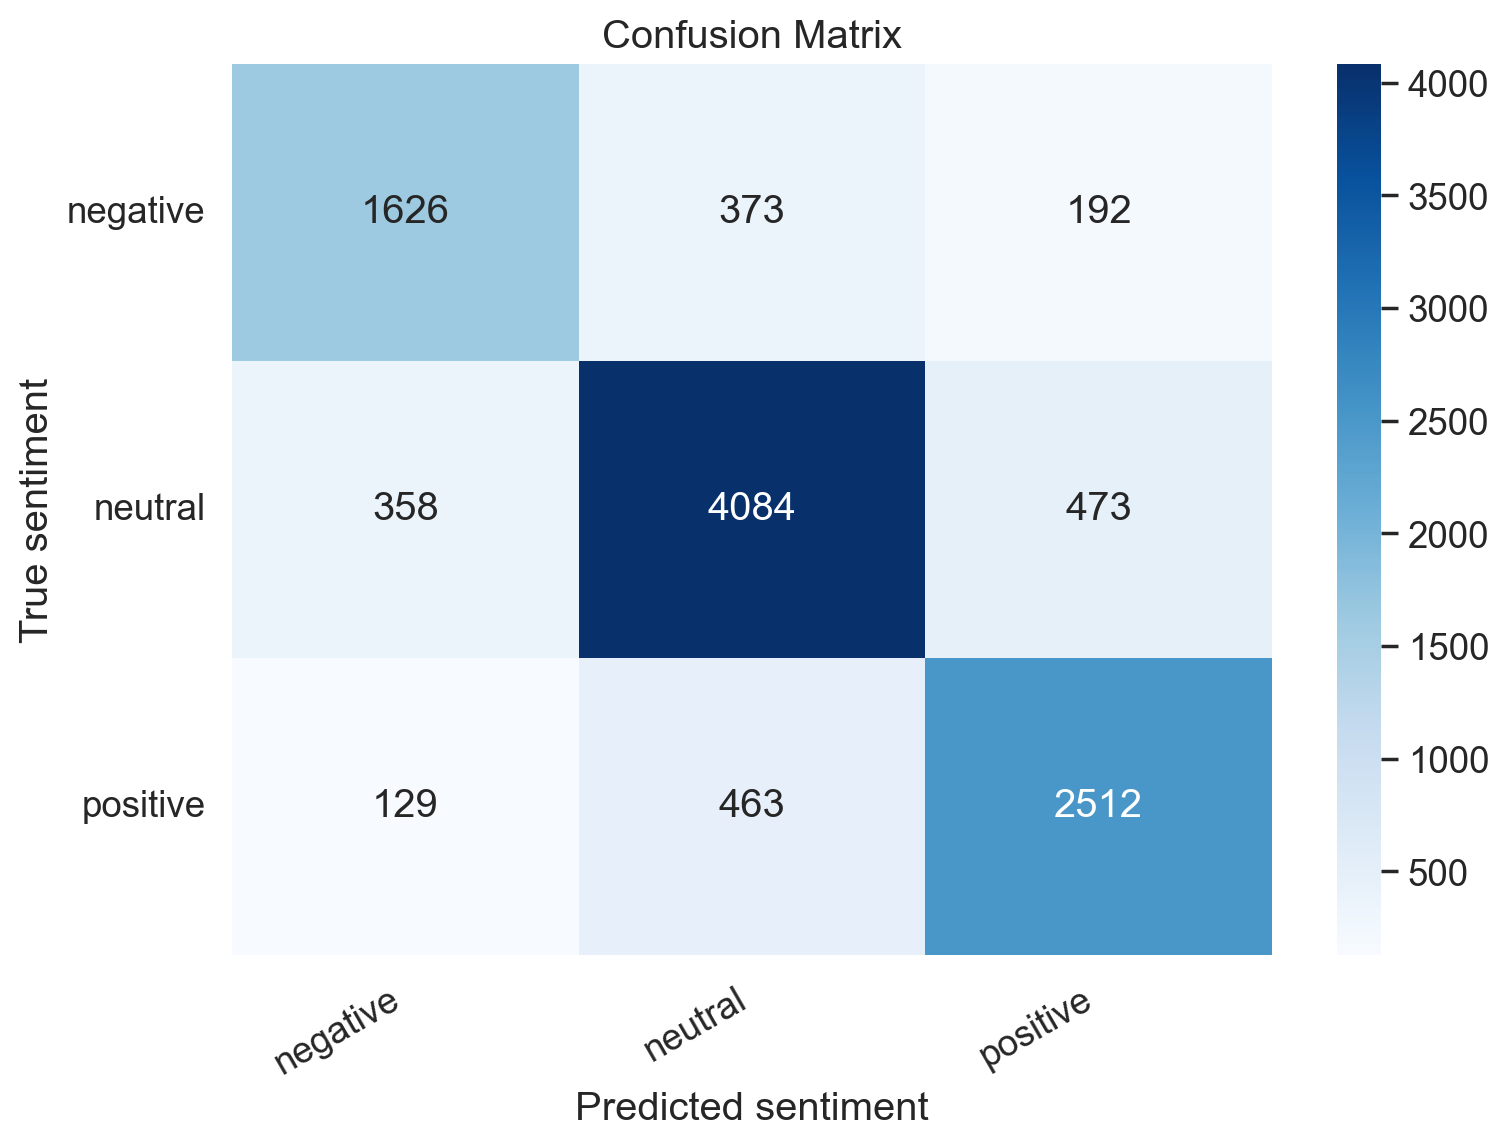

In [12]:
plot_confusion_matrix(y_test, y_pred, class_names)

In [13]:
neg_label = 0  # assuming 'negative' is label 0
pos_label = 2  # assuming 'positive' is label 2

# False negatives for positive = positives predicted as negative
false_negatives_pos = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == pos_label and pred == neg_label]

# False positives for positive = negatives predicted as positive
false_positives_pos = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == neg_label and pred == pos_label]

print("False negatives for positive (missed positives):", len(false_negatives_pos))
print("False positives for positive (wrongly predicted positives):", len(false_positives_pos))
print()

for i in false_negatives_pos[:10]:
    print(f"Text: {test_df.iloc[i]['text']}")
    print(f"True label: {class_names[y_test[i]]}, Predicted: {class_names[y_pred[i]]}")
    print("-"*80)

False negatives for positive (missed positives): 129
False positives for positive (wrongly predicted positives): 192

Text: Alas, I should've had more faith in my beloved Trader's.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: I got nauseous and before I could even let someone know, 3-4 staff members ran over and were placing cold packs under my clothes and talking me through it.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Amazingly dopey .
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Show is 90 minutes long and doesn't feel like it at all.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Try: The Vito with hot peppers

Avoid: The mayo on the Italian Nightclub

In [14]:
fn_pos_df = test_df.iloc[false_negatives_pos].copy()
fp_pos_df = test_df.iloc[false_positives_pos].copy()

## Augmentation at test time - paraphrasing

In [40]:
output = generate_variations(llama_pipeline, paraphrasing_prompt,
                             "I had a severe allergic reaction that caused my eyes to swell, itch, and burn.")

variations_list = extract_generated_variations(output)

In [41]:
final_preds = []
for text in tqdm(fn_pos_df.text):  # your test_texts list
    pred, preds_all = predict_with_majority_voting(roberta_model, roberta_tokenizer, llama_pipeline, text, paraphrasing_prompt, device)
    final_preds.append(pred)

  1%|          | 1/129 [00:13<27:47, 13.03s/it]


KeyboardInterrupt: 

final_preds = [0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2]

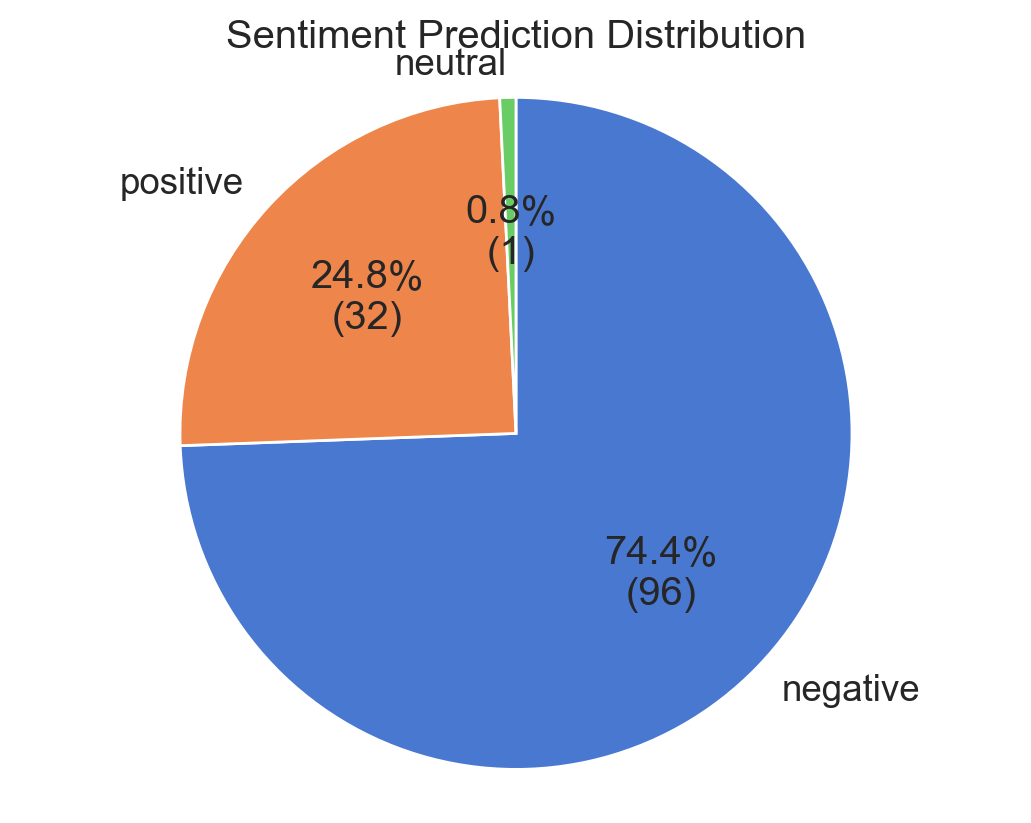

In [28]:
import matplotlib.pyplot as plt
from collections import Counter
from config.config import LABEL_MAPPING_NUMBER_TO_STRING

# Count occurrences
counts = Counter(final_preds)

# Map numeric labels to string labels
labels = [LABEL_MAPPING_NUMBER_TO_STRING[label] for label in counts.keys()]
sizes = list(counts.values())

# Custom label formatter to show both count and percentage
def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return inner_autopct

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct=autopct_format(sizes),
       startangle=90,
       counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.title("Sentiment Prediction Distribution")
plt.show()

In [29]:
plot_confusion_matrix(y_test, final_preds, class_names)

ValueError: Found input variables with inconsistent numbers of samples: [10210, 129]

In [26]:
final_preds

[0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2]